In [1]:
from imutils.video import FPS
from imutils.video import FileVideoStream
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from imutils.video import count_frames 
SHAPE = [1080,1920]
vid_file='~/Google Drive File Stream/My Drive/proff/Holzman/Larvae_vids/03.06.20 13DPH.mp4'#23.02.2020 - frames 327651-611615.mp4'
#28.11.2019 - frames 452348-452578.avi'
#23.02.2020 - frames 484503-484953.avi'
#11.12.2019 - frames 64935-65415.avi'#09.60.20 19DPH.mp4'
#23.02.2020 - frames 332698-333038.avi'#03.06.20 13DPH.mp4'#23.02.2020 - frames 327651-611615.mp4'#11.12.2019.mp4'#'#
output_vid_name='trial1.avi'

In [2]:
def get_centroid(x, y, w, h):
    """ Get bounding box centroid"""
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)
def proximity(contour_list,contour):
    curr_x, curr_y, curr_w, curr_h   = contour
    too_close=[]
    for i,neighbor in enumerate(contour_list):
        nx, ny, nw, nh = neighbor[0]
        if abs(curr_x-nx)<60 or abs(curr_y-ny)<60:
            too_close.append(i)
    return too_close

def get_contours(image,min_width=50,min_height=50):
    """ Get the blobs or contours detected in the image
    input: 
    image - a frame
    min_width - the minimal width of a blob, all blobs below threshold will be disregarded
    min_height - the minimal width of a blob, all blobs below threshold will be disregarded
    returns: 
    matches - a list of tuples, each tuple contains two tuples with information about each detected blob.
        first tuple is the bounding box coordinates, width and height 
        second tuple contains the centroid coordinates
    """
    matches = []
    # find all contours/blobs in the frame:
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    for (i, contour) in enumerate(contours):
        # for each detected object/blob/contour
        # Get the bounding box:
        (x, y, w, h) = cv2.boundingRect(contour)
        # Filter by height and width:
        contour_valid = (w >= min_width) and (
                    h >= min_height)

        if not contour_valid:
            continue     
        # Get bbox centroid:
        centroid = get_centroid(x, y, w, h)
        neighbors=proximity(matches,(x, y, w, h))
        if neighbors:
            for n in neighbors:
                neighbor=matches.pop(n)
                xn,yn,wn,hn =neighbor[0]
                if xn>x:
                    xn=x
                if yn>y:
                    yn=y 
                new_centroid=(round((centroid[0]+neighbor[1][0])/2), round((centroid[1]+neighbor[1][1])/2))
                matches.append(((xn,yn,wn,hn),new_centroid))
        
        else:    
            matches.append(((x, y, w, h), centroid))
    return matches

def draw_boxes(img, pathes):
    """ Draw bounding boxes around objects in image
    """
    BOUNDING_BOX_COLOUR = (255, 10, 0) #BGR
    CENTROID_COLOUR = (255, 192, 0) #BGR
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for (i, match) in enumerate(pathes):
        contour, centroid = match
        x, y, w, h = contour
        subframe=gray[y:y+h,x:x+w]
        lap=cv2.Laplacian(subframe, cv2.CV_64F).var()
        cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 4)
        cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)
        #cv2.putText(img, f'{lap:.2f}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    return img

def get_filter(frame,bg_sub,brighten=True,blur=False):
    """ Get the foreground mask for a frame
    input:
    frame - frame from video
    bg_sub - an open-cv pre-trained background subtractor
    brighten - bool, whether to adjust brightness in the image
    blur - bool, whether to apply gaussian blur to remove background noise from the image
    output:
    combined - a foreground mask created by fine-tuning the background subtractor output with edge detection.
    """
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Turn to grayscale 
    denoise=cv2.GaussianBlur(gray,(71,71),0) 
    if blur:
        # Apply gaussian blur to image
        gray=denoise
    if brighten:
        # Apply brightness adjustment to image
        gray=cv2.convertScaleAbs(gray, alpha=1, beta=50)
    fg_mask = bg_sub.apply(gray, None, 0.001) # calculate foreground mask
    img=cv2.Canny(denoise,10,10) # get edges from the blurred image to filter out small floating particles
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10)) 
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) # fill in gaps in the edges
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    # Dilate to merge adjacent blobs
    dilation = cv2.dilate(opening, kernel, iterations=2)
    # get the areas that are detected by both the bg-sub and the edge detection routine:
    combined=cv2.bitwise_and(fg_mask,closing) 
    return combined

def train_bg_subtractor(cap, bg_sub, num, brighten=True, blur=False):
    """ Pre-train the background subtractor.
    input:
    cap - video capture object, the video
    bg_sub - background subtractor object
    num - number of frames to train on
    brighten - bool, whether to adjust brightness in the image
    blur - bool, whether to apply gaussian blur to remove background noise from the image
    output:
    bg_sub - trained background subtractor
    """
    for i in range(num):
        # iterate over the selected number of frames
        #ret,frame=cap.read() # get one frame
        _,frame=cap.read()
        gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale 
        if brighten:
            # modify brightness if applicable:
            gray=cv2.convertScaleAbs(gray, alpha=1, beta=50)
        if blur:
            # apply gaussian blur if applicable:
            gray=cv2.GaussianBlur(gray,(71,71),0)
        fg_mask=bg_sub.apply(gray, None, 0.001) #apply bg_sub to the frame (modified or not)
    return bg_sub 

def save_frame(frame, file_name, flip=True):
    """ Save  frame as image"""
    # flip BGR to RGB
    if flip:
        cv2.imwrite(file_name, np.flip(frame, 2))
    else:
        cv2.imwrite(file_name, frame)
        
        
def process_vid(vid_name,output_vid,brighten=True,blur=False):
    """ Detect objects in a single video and create a new video with the bounding boxes around objects.
    input:
    vid_name - path and filename of the input video
    output_vid - path and filename for the generated video
    brighten - bool, whether to adjust brightness in the image
    blur - bool, whether to apply gaussian blur to remove background noise from the image
    """
    # count the number of frames in the video, so we can determine the portion dedicated for training
    # the background subtractor:
    #num_frames=#count_frames(vid_name) 
    cap=cv2.VideoCapture(vid_name) # open video
    train_frames=500#round(num_frames/4) # number of frames to pre-train the bg_sub on
    bg_sub=cv2.createBackgroundSubtractorMOG2(history=train_frames,detectShadows=True) 
    bg_sub=train_bg_subtractor(cap, bg_sub,train_frames) # pre-training
    # codec for video writing, see: https://www.pyimagesearch.com/2016/02/22/writing-to-video-with-opencv/
    fourcc = cv2.VideoWriter_fourcc(*"MJPG") 
    # the video writer is defined by output filename, selected codec, the fps selected is the same as the input video, 
    # frame size that is also identical to input video, and a boolean specific whether to save a color video:
    writer = cv2.VideoWriter(output_vid, fourcc, cap.get(cv2.CAP_PROP_FPS), (SHAPE[1], SHAPE[0]), True)
    # iterate over the remaining frames:
    while True:
        grabbed,frame=cap.read() # get frame
        if not grabbed:
            break
        mask=get_filter(frame,bg_sub) # get foreground mask
        matches=get_contours(mask) # find objects inside the mask, get a list of their bounding boxes
        img1=[] 
        img1=draw_boxes(frame,matches) # draw bounding boxes on original frame
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # optional: open-cv work in BGR so convert back to RGB
        writer.write(img1) # Write frame to the new video file
        #fps.update()
   # release resources:     
    writer.release()
    cap.release()


    

In [42]:
fps = FPS().start()
process_vid(os.path.expanduser(vid_file),output_vid_name,brighten=False,blur=True)
fps.stop()

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

[INFO] elasped time: 733.55
[INFO] approx. FPS: 0.00


[((276, 976, 111, 76), (331, 1014)), ((225, 173, 63, 77), (256, 211)), ((431, 93, 99, 68), (480, 127)), ((1794, 69, 111, 50), (1849, 94))]


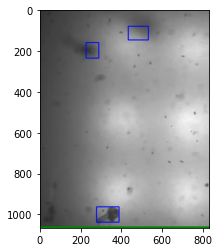

In [84]:
print(matches)
#plt.imshow(img1[276:(276+111)][976:(976+76)])
img1.shape
plt.imshow(img1[0:(94+500),1349:(1849+500)])
plt.imshow(img1[(514-500):1514,0:831])
#plt.imshow(img1)

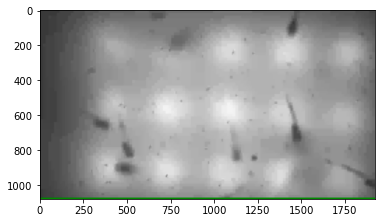

In [62]:
fvs = FileVideoStream(os.path.expanduser(vid_file)).start()
img=fvs.read()
plt.imshow(img)

In [63]:
msk=get_filter(img,bg_sub)
#conts=get_contours(msk)
#im2=draw_boxes(img,conts)

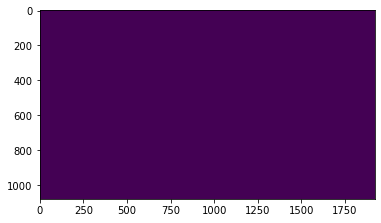

In [64]:
plt.imshow(msk)

In [44]:
# cut out an example vid for Roi
c=cv2.VideoCapture(output_vid_name)
images=[]
fourcc = cv2.VideoWriter_fourcc(*"MJPG") 
writer = cv2.VideoWriter('fish_example.avi', fourcc, 60, (SHAPE[1], SHAPE[0]), True)

for i in range(450):
    _,frame=c.read()
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    writer.write(frame)
    #images.append(Image.fromarray(frame))
writer.release()
c.release()
#images[0].save('fish.gif',
 #              save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

In [23]:
def train_bg_subtractor2(cap, bg_sub, num, brighten=True, blur=False):
    """ Pre-train the background subtractor.
    input:
    cap - video capture object, the video
    bg_sub - background subtractor object
    num - number of frames to train on
    brighten - bool, whether to adjust brightness in the image
    blur - bool, whether to apply gaussian blur to remove background noise from the image
    output:
    bg_sub - trained background subtractor
    """
    for i in range(num):
        # iterate over the selected number of frames
        #ret,frame=cap.read() # get one frame
        frame=cap.read()
        gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale 
        if brighten:
            # modify brightness if applicable:
            gray=cv2.convertScaleAbs(gray, alpha=1, beta=50)
        if blur:
            # apply gaussian blur if applicable:
            gray=cv2.GaussianBlur(gray,(71,71),0)
        fg_mask=bg_sub.apply(gray, None, 0.001) #apply bg_sub to the frame (modified or not)
    return bg_sub 


def process_vid2(vid_name,output_vid,brighten=True,blur=False):
    num_frames=count_frames(os.path.expanduser(vid_file)) 
    train_frames=round(num_frames/4) # number of frames to pre-train the bg_sub on
    bg_sub=cv2.createBackgroundSubtractorMOG2(history=train_frames,detectShadows=True) 

    fvs = FileVideoStream(vid_name).start()
    bg_sub=train_bg_subtractor2(fvs, bg_sub,train_frames)
    time.sleep(1.0)
    # start the FPS timer
    fourcc = cv2.VideoWriter_fourcc(*"MJPG") 
    # the video writer is defined by output filename, selected codec, the fps selected is the same as the input video, 
    # frame size that is also identical to input video, and a boolean specific whether to save a color video:
    writer = cv2.VideoWriter(output_vid, fourcc, 30, (SHAPE[1], SHAPE[0]), True)
    
    while fvs.more():
        # grab the frame from the threaded video file stream, resize
        # it, and convert it to grayscale (while still retaining 3
        # channels)
        frame = fvs.read()

        if frame is None:
            break

        mask=get_filter(frame,bg_sub) # get foreground mask
        matches=get_contours(mask) # find objects inside the mask, get a list of their bounding boxes
        img1=[] 
        img1=draw_boxes(frame,matches) # draw bounding boxes on original frame
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # optional: open-cv work in BGR so convert back to RGB
        writer.write(img1) # Write frame to the new video file
        fps.update()
        # display the size of the queue on the frame
        #cv2.putText(frame, "Queue Size: {}".format(fvs.Q.qsize()),
         #   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        # show the frame and update the FPS counter
        #cv2.imshow("Frame", frame)
        #cv2.waitKey(1)
    
    # stop the timer and display FPS information
    

print("[INFO] starting video file thread...")
fps = FPS().start()# loop over frames from the video file stream
process_vid(os.path.expanduser(vid_file),output_vid_name,brighten=False,blur=True)
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
# do a bit of cleanup
cv2.destroyAllWindows()
fvs.stop()

[INFO] starting video file thread...


NameError: name 'process_vid' is not defined

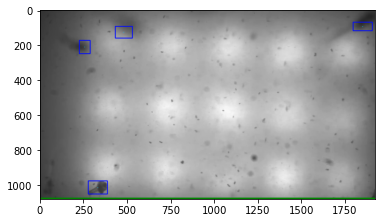

In [30]:
plt.imshow(img1)

In [63]:
count_frames('fish_example.avi')


30

40

In [32]:
PADDING_SIZE=250
MOVIE_FPS=30

folder_name=''.join(vid_file.split(os.path.sep)[-1].split('.')[0:-1])
try:
    os.mkdir(folder_name)
except FileExistsError:
    folder_name=folder_name+'2'
    os.mkdir(folder_name)
MOVIE_FORMAT='.avi'
#num_frames=count_frames(os.path.expanduser(vid_file)) 
train_frames=500#round(num_frames/4) # number of frames to pre-train the bg_sub on
cap=cv2.VideoCapture(os.path.expanduser(vid_file))
bg_sub=cv2.createBackgroundSubtractorMOG2(history=train_frames,detectShadows=True) 
fps = FPS().start()# loop over frames from the video file stream
bg_sub=train_bg_subtractor(cap, bg_sub,train_frames) # pre-training
counter=0
movie_counter=0
contour_dict={}
movie_dict={}
MOVIE_NAME='cutout_'
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
med_laplacian=[]
log=pd.DataFrame(columns=['movie_name','frame','coordinates','label'])
idx=0
while True:
    grabbed,frame=cap.read() # get frame
    if not grabbed:
        break
    if counter%80 == 0:
        mask=get_filter(frame,bg_sub) # get foreground mask
        matches=get_contours(mask) # find objects inside the mask, get a list of their bounding boxes
        movie_counter=0
        for match in matches:
            contour, centroid = match
            #x, y, w, h = contour
            #subframe=frame[y:y+h,x:x+w]
            #subframe=cv2.cvtColor(subframe, cv2.COLOR_BGR2GRAY)
            #lap=cv2.Laplacian(subframe, cv2.CV_64F).var()
            #if lap>3.5:
            if match not in contour_dict.keys():
                x1=centroid[1]-PADDING_SIZE
                if x1<0:
                    x1=0
                x2=centroid[1]+PADDING_SIZE
                if x2>SHAPE[0]:
                    x2=SHAPE[0]
                y1=centroid[0]-PADDING_SIZE
                if y1<0:
                    y1=0
                y2=centroid[0]+PADDING_SIZE
                if y2>SHAPE[1]:
                    y2=SHAPE[1]
                contour_dict[match]=[(x1,x2),(y1,y2),0,[]]
                new_name=MOVIE_NAME+'frame'+str(counter)+'fish'+str(movie_counter)+MOVIE_FORMAT
                movie_path=folder_name+os.path.sep+new_name
                movie_dict[match]=[cv2.VideoWriter(movie_path, fourcc,
                                                MOVIE_FPS, (PADDING_SIZE*2, PADDING_SIZE*2), False), movie_path]
                log.loc[idx,:]={'movie_name':new_name,'frame':counter,'coordinates':centroid,'label':None}
                idx+=1
                movie_counter+=1
                
    for key in list(contour_dict):
        entry=contour_dict[key]
        if entry[2]==101:
            med_laplacian.append(np.mean(entry[3]))
            contour_dict.pop(key)
            tmp=movie_dict.pop(key)
            
            tmp[0].release()
            if med_laplacian[-1]<4:
                os.remove(tmp[1])
                log.drop(log[log.movie_name==tmp[1]].index,inplace=True)
            continue
        cutout=[]
        contour, centroid = match
        x, y, w, h = contour
        subframe=frame[y:y+h,x:x+w]
        subframe=cv2.cvtColor(subframe, cv2.COLOR_BGR2GRAY)
        lap=cv2.Laplacian(subframe, cv2.CV_64F).var()
        cutout=frame[entry[0][0]:entry[0][1],entry[1][0]:entry[1][1]]
        cutout=cv2.cvtColor(cutout, cv2.COLOR_BGR2GRAY)
        #lap=cv2.Laplacian(cutout, cv2.CV_64F).var()
        entry[3].append(lap)
        output = np.zeros((PADDING_SIZE * 2, PADDING_SIZE * 2), dtype="uint8")
        output[0:cutout.shape[0],0:cutout.shape[1]]=cutout
        movie_dict[key][0].write(output)
        entry[2]+=1
    counter+=1
    fps.update()
for movie in movie_dict.values():
    movie[0].release()
cap.release()
fps.stop()
log.to_csv(folder_name+os.path.sep+'log.csv',index=False)

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))        


[INFO] elasped time: 142.93
[INFO] approx. FPS: 39.17


In [56]:
log.drop(log[log.movie_name=='fish_cutoutframe0fish0.avi'].index,inplace=True)

[INFO] elasped time: 106.26
[INFO] approx. FPS: 43.05

In [37]:
log.head()

,movie_name,frame,coordinates,label
0,cutout_frame0fish0.avi,0,"(864, 702)",None
1,cutout_frame0fish1.avi,0,"(941, 411)",None
2,cutout_frame80fish0.avi,80,"(480, 892)",None
3,cutout_frame80fish1.avi,80,"(1630, 670)",None
4,cutout_frame80fish2.avi,80,"(1071, 411)",None


In [44]:
log.loc[log.movie_name=='cutout_frame0fish0.avi'].label.values[0]

In [101]:
movie_dict

{}

In [105]:
movie_counter

213

In [61]:
vid_file.split('/')[-1]

'03.06.20 13DPH.mp4'

In [9]:
tmp_dict[0]

[(452, 952), (1457, 1957), 101]

In [5]:
tmp_dict

{0: [(0, 470), (1492, 1992), 101],
 1: [(0, 476), (1401, 1901), 101],
 2: [(0, 463), (1293, 1793), 101],
 3: [(42, 542), (1088, 1588), 101],
 4: [(0, 492), (1024, 1524), 41],
 5: [(0, 389), (743, 1243), 41]}

In [31]:
log[log.movie_name==titles_to_remove]


ValueError: Lengths must match to compare

In [15]:
tmp

<VideoWriter 0x131a44c10>

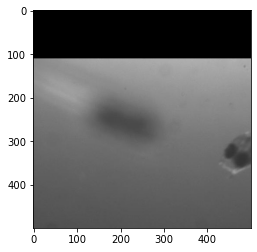

In [36]:
plt.imshow(cutout)

(array([  56.,  863., 1452.,  791.,  360.,  138.,   67.,   27.,    4.,
           4.]),
 array([ 1.27706972,  2.19177917,  3.10648863,  4.02119809,  4.93590754,
         5.850617  ,  6.76532646,  7.68003591,  8.59474537,  9.50945483,
        10.42416428]),
 <a list of 10 Patch objects>)

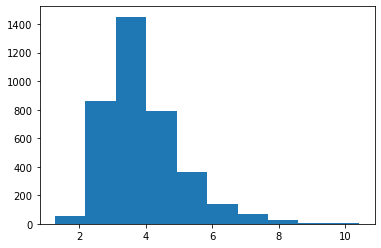

In [6]:
plt.hist(med_laplacian)

In [34]:
cutout=frame[entry[0][0]:entry[0][1],entry[1][0]:entry[1][1]]

TypeError: 'NoneType' object is not subscriptable

In [42]:
movie_dict[key].write(cutout)
movie_dict[key].release()

In [38]:
movie_dict

{((1217, 206, 114, 72), (1274, 242)): <VideoWriter 0x18d14d1d0>,
 ((946, 114, 95, 51), (993, 139)): <VideoWriter 0x18d14d650>}

In [43]:
cutout

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[79, 79, 79],
        [80, 80, 80],
        [80, 80, 80],
        ...,
        [85, 85, 85],
        [85, 85, 85],
        [85, 85, 85]],

       [[79, 79, 79],
        [79, 79, 79],
        [79, 79, 79],
        ...,
        [84, 84, 84],
        [84, 84, 84],
        [84, 84, 84]],

       [[79, 79, 79],
        [79, 79, 79],
        [79, 79, 79],
        ...,
        [84, 84, 84],
        [84, 84, 84],
        [84, 84, 84]]], dtype=uint8)

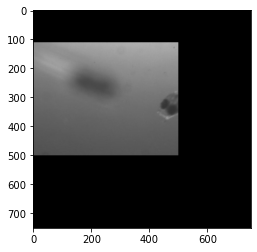

In [46]:
out=np.zeros((PADDING_SIZE * 3, PADDING_SIZE * 3, 3), dtype="uint8")
out[0:cutout.shape[0],0:cutout.shape[1]]=cutout
plt.imshow(out)

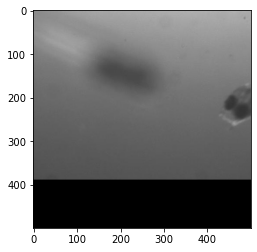

In [50]:
plt.imshow(output)

In [59]:
movie_counter

188

In [99]:
np.median([1,2,34,6,7,4,4,4])

4.0

In [103]:
writer=cv2.VideoWriter(new_name, fourcc,
                                                MOVIE_FPS, (PADDING_SIZE*2, PADDING_SIZE*2), False)

In [120]:
writer.new_name

AttributeError: 'cv2.VideoWriter' object has no attribute 'new_name'

In [ ]:
import tkinter aw